In [44]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
tf.__version__

'2.16.2'

# Background on the dataset

The dataset was downloaded from [kaggle](https://www.kaggle.com/datasets/msambare/fer2013/data) and derived from a [2013 Facial Recognition Kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

"The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples."

## Explore the Image metadata

We will use the training set for exploratory analysis. It consists of 27,709 examples of facial expressions.

The data I downloaded didn't come with a metadata overview so I have written a function to extract some key bits of information and verify the following assumptions:

- all the images are 48x48 pixels
- all the images are grayscale

In [51]:
# https://pillow.readthedocs.io/en/stable/handbook/concepts.html
modes = {
    '1' :'1-bit pixels, black and white, stored with one pixel per byte',
    'L': '8-bit pixels, grayscale',
    'P' :'8-bit pixels, mapped to any other mode using a color palette',
    'RGB': '3x8-bit pixels, true color',
    'RGBA': '4x8-bit pixels, true color with transparency mask',
    'CMYK': '4x8-bit pixels, color separation',
    'YCbCr': '3x8-bit pixels, color video format',
    'LAB':'3x8-bit pixels, the L*a*b color space',
    'HSV': '3x8-bit pixels, Hue, Saturation, Value color space',
    'I' :'32-bit signed integer pixels',
    'F' :'32-bit floating point pixels'
}
    
def get_meta(data_path):
    file_meta = []
    

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)
        
            stats = os.stat(image_filepath)
            img = Image.open(image_filepath)
            
            width, height = img.size

            mode = img.mode
            
            attrs = {
                'category': name,
                'file_name': image_file_name,
                'file_path': image_filepath,
                'size_kb': round(stats.st_size/1024,2),
                'dimensions': f"{width}x{height}",
                'mode': mode,
                'mode_desc': modes.get(mode, 'unknown'),
                'image_format': img.format,
                'is_jpg_extension': '.jpg' in image_file_name
            
                
            }
            file_meta.append(attrs)
    

    
    return file_meta 

In [52]:
test_data_folder = "../data/FER-2013/train/"

meta = get_meta(test_data_folder)

df_meta = pd.DataFrame(meta)
df_meta.head()

,category,file_name,file_path,size_kb,dimensions,mode,mode_desc,image_format,is_jpg_extension
0,happy,Training_50449107.jpg,../data/FER-2013/train/happy/Training_50449107...,1.45,48x48,L,"8-bit pixels, grayscale",JPEG,True
1,happy,Training_70433018.jpg,../data/FER-2013/train/happy/Training_70433018...,1.35,48x48,L,"8-bit pixels, grayscale",JPEG,True
2,happy,Training_85610005.jpg,../data/FER-2013/train/happy/Training_85610005...,1.43,48x48,L,"8-bit pixels, grayscale",JPEG,True
3,happy,Training_4460748.jpg,../data/FER-2013/train/happy/Training_4460748.jpg,1.41,48x48,L,"8-bit pixels, grayscale",JPEG,True
4,happy,Training_6312930.jpg,../data/FER-2013/train/happy/Training_6312930.jpg,1.66,48x48,L,"8-bit pixels, grayscale",JPEG,True


In [39]:
df_meta.describe()

,size_kb
count,28709.000000
mean,1.537030
std,0.158096
min,0.350000
25%,1.440000
50%,1.540000
75%,1.640000
max,2.340000


### Randomly sampling images

A random sample of the data reveals that:

- not all the data are photographs of real people: we have at least one cartoon!
- the lighting is inconsistent
- some of the images are blurry
- some of the images have marks on them

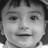

In [6]:
df_meta_sample = df_meta.sample(n=50, replace=False, random_state=42)
df_sample_file_paths = df_meta_sample["file_path"]
categories = list(df_meta_sample["category"])

sample_images = [load_img(image_path) for image_path in df_sample_file_paths]
sample_images[0]

happy 0


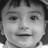

sad 1


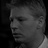

angry 2


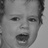

happy 3


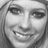

angry 4


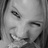

happy 5


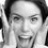

happy 6


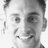

angry 7


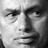

happy 8


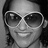

surprise 9


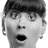

fear 10


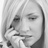

neutral 11


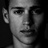

surprise 12


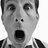

sad 13


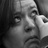

happy 14


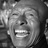

neutral 15


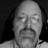

neutral 16


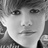

disgust 17


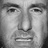

happy 18


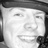

angry 19


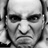

fear 20


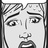

neutral 21


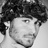

fear 22


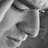

neutral 23


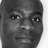

sad 24


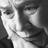

happy 25


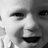

neutral 26


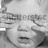

sad 27


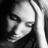

happy 28


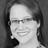

happy 29


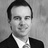

neutral 30


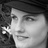

sad 31


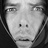

happy 32


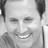

sad 33


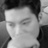

angry 34


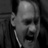

angry 35


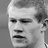

fear 36


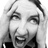

sad 37


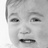

sad 38


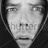

happy 39


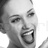

happy 40


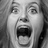

sad 41


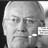

angry 42


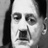

sad 43


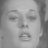

sad 44


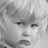

sad 45


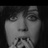

surprise 46


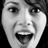

angry 47


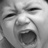

happy 48


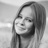

angry 49


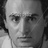

In [7]:
for i, img in enumerate(sample_images):
    print(categories[i], i)
    display(img)

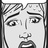

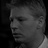

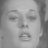

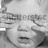

In [8]:
cartoon_image = sample_images[20]
dark_image = sample_images[1]
blurry_image = sample_images[43]
watermark_image = sample_images[26]
display(cartoon_image, dark_image,  blurry_image, watermark_image)

### Image resolution

All of our training data is 48 x 48 pixels. This is fairly small but since our classification task is quite simple, it is ok.

In [9]:
df_meta["dimensions"].value_counts()

dimensions
48x48    28709
Name: count, dtype: int64

### File format

All the image files are JPEGs.

In [54]:
df_meta["image_format"].value_counts()

image_format
JPEG    28709
Name: count, dtype: int64

### Data Type

All of our data is grayscale.

In [10]:
df_meta["mode_desc"].value_counts()

mode_desc
8-bit pixels, grayscale    28709
Name: count, dtype: int64

### Image file size

All our files are under 2.35 KB. They are all small compressed images which can mean that the quality might be degraded: we have already seen from our random selection that there is some blurring. On a plus point, smaller sizes usually mean faster training time.

If the image quality is degraded there are some techniques we could use:
- data augmentation: by modifying the existing images (rotating, scaling, brightness adjustments) you can make the model become more robust to noise
- noise reduction: the compression process may have introduced noise into the image, we can use algorithms to remove or reduce noise

In [34]:
df_meta["size_kb"].describe()

count    28709.000000
mean         1.537030
std          0.158096
min          0.350000
25%          1.440000
50%          1.540000
75%          1.640000
max          2.340000
Name: size_kb, dtype: float64

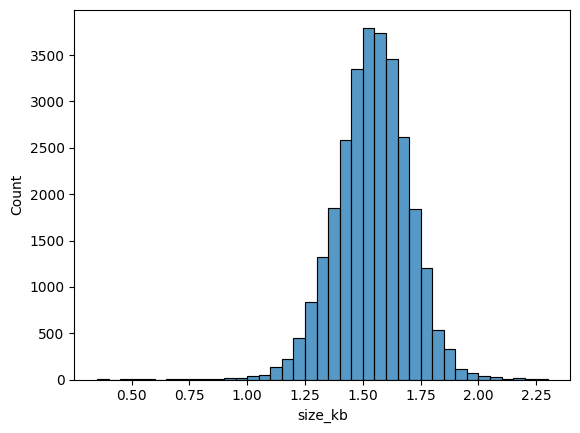

In [35]:
bin_edges = np.arange(0.35, 2.35, 0.05)
sns.histplot(data = df_meta, x="size_kb", bins=bin_edges)
plt.show()

### Class distribution

Our training images have been categorised into 7 different emotions: 
- angry
- disgust
- fear
- happy
- neutral
- sad
- surprise

We can see that the distribution across classes is very imbalanced with over 25% of the images categorised as "happy". 

Having an imbalanced dataset can lead to models that do not generalise well to other datasets. There are a couple of strategies for overcoming this imbalance that we can look at when training our model e.g. 

- **data augmentation**: we can create new images of underrepresented categories (e.g. "disgust") by making small adjustments to images in that class and adding them to our dataset. You don't need to create a perfect 1:1 ratio with the majority class, just bring the number closer.
- **class weights**: we can tell the algorithm to penalise the misclassification of the underrepresented categories more. Misclassifying these categories will have a larger impact on the overall loss. All of the categories contribute to the loss but by applying different weights - higher for underrepresented, lower for overrepresented, we can balance out their representation. Some experimentation is needed to find the best weight. A good starting off point is to make the weights inversely proportional to the number of samples in each class

In [11]:
df_meta["category"].value_counts(normalize=True)

category
happy       0.251315
neutral     0.172942
sad         0.168240
fear        0.142708
angry       0.139155
surprise    0.110453
disgust     0.015187
Name: proportion, dtype: float64

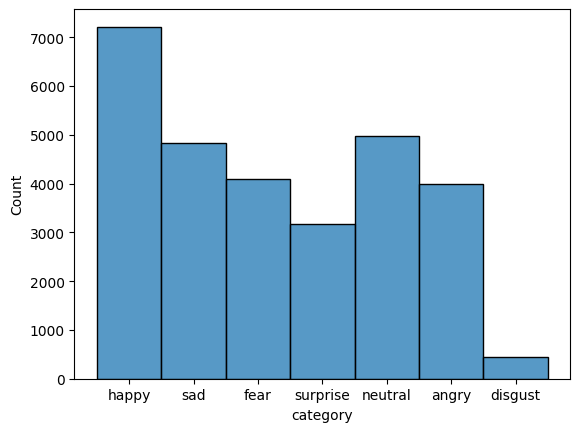

In [12]:
sns.histplot(data=df_meta, x="category")
plt.show()

## TODO

- how can we identify and fix noise?
- how can we handle blurry images, watermarked images, and dark images?

In [48]:
images = [load_img(image_path) for image_path in df_meta["file_path"]]
image_arrays = [img_to_array(image) for image in images]

### Visualizing a histogram of pixel intensities

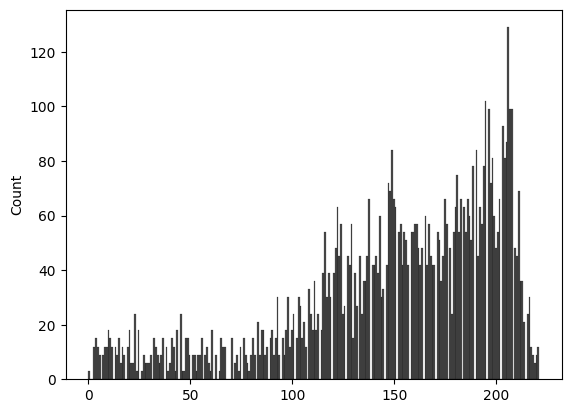

In [47]:
sns.histplot(data=image_arrays[0].ravel(), bins=256, color='black', alpha=0.7)
plt.show()